# Experimental Nuclear Reaction Data (EXFOR)

In this notebook we explore the EXFOR dataset and showcase some of the plotting and data manipulation capabalities of NucML. Let us start by importing some of the needed modules.

In [1]:
# # Prototype
# import sys
# sys.path.append("../../")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

import nucml.datasets as nuc_data

In [3]:
sns.set(font_scale=2)
sns.set_style("white")

# Setting up the path where our figures will be stored
figure_dir = "./Figures/"

**NOTE: WHEN WE TALK ABOUT CROSS SECTIONS WE ARE REFERING TO THE FEATURE NAMED "DATA", WHICH IS OUR LABEL**

## Loading the EXFOR Database

Let us study the dataset feature by feature. First we load our dataset. **Our focus is on low energy physics so we shall limit our dataset to these energies first (< 20 MeV)**.

In [4]:
df = nuc_data.load_exfor()
df.MT = df.MT.astype(int)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: False
INFO:root: LOG: False
INFO:root: BASIC: -1
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4255409, 104)
INFO:root:Finished. Resulting dataset has shape (4255409, 104)


In [5]:
# df_original[df_original.Data == 0].shape

In [6]:
df = df[df.Energy <= 2E7]

## Understanding the Challenge

Before we start analyzing the features of the EXFOR database, we must understand the challenge and the complexity of it. 

The goal here is to be able to predict cross-section values for a variety of reaction channels and isotopes. These cross-section values are probabilities although not in the usual 0-1 scale. Throughout the world, experimental measurements are performed to gather data that can then be used in traditional physics-based modeling to create a set of recommended values. Let us look at the Uranium-235(n,gamma) reaction.

The `nucml.exfor.data_utilities` module contains the main functions to deal with EXFOR. Let us start by plotting the fission reaction for Uranium 235.

In [7]:
import nucml.exfor.data_utilities as exfor_utils

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (133028, 104)


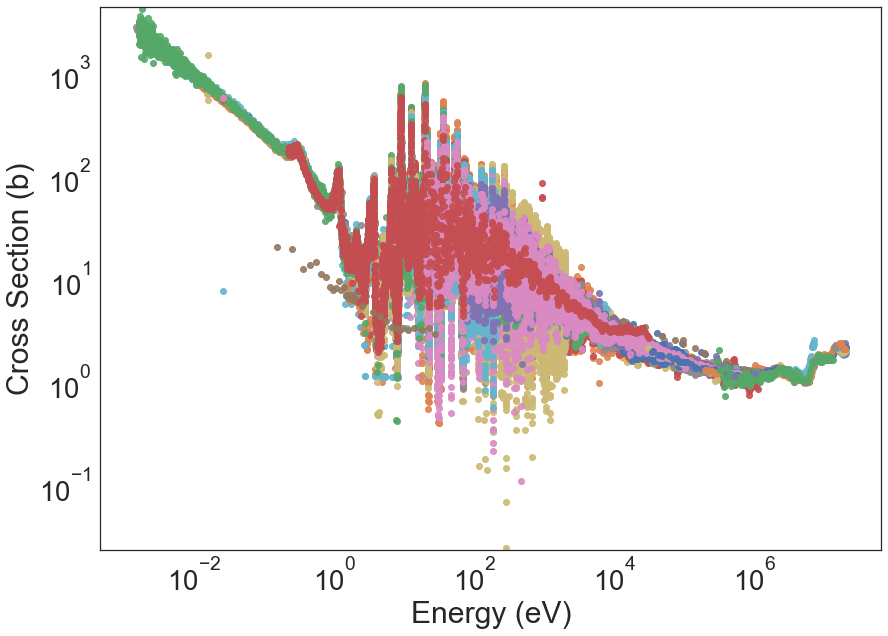

In [8]:
kwargs = {"nat_iso":"I", "one_hot":False, "alpha":0.9, "legend":False, "interpolate":False, "log_plot":True, "ref":True}

u_exfor_endf = exfor_utils.plot_exfor_w_references(
    df, 92, 235, 18, get_endf=False, error=True, save=True, path=figure_dir, **kwargs)

Here, each color represents a different experimental campaign. Researchers use different methods for their measurements that also carry different data processing methodologies. There is not standardize measurement technique, therefore, introducing uncertainties. In the following sections, we try to analyze the features that may affect the cross section behavior. The EXFOR database contains experimental measurements not only for one isotope like uranium but for 96 more isotopes and 36 total reactions. That is a total of 3492 combinations of isotope, reaction types. 

## Energy Distribution

We know that the reaction probability is a function of energy, isotope, and reaction type. All of these are important and fundamental. Since Energy is perhaps one of the most important features so we shall start by analyzing this feature. 

In [10]:
df.Energy.describe() # vanilla statistics

count    4.197495e+06
mean     1.074256e+06
std      2.620195e+06
min      0.000000e+00
25%      4.326000e+02
50%      2.484900e+04
75%      7.706700e+05
max      2.000000e+07
Name: Energy, dtype: float64

In [11]:
df = df[df.Energy != 0] # Energy cannot be 0 physically so we drop these

In [12]:
from scipy.stats import skew
skew(df.Energy.values)

3.851943394525566

Text(0.5, 1.0, 'Energy Distribution')

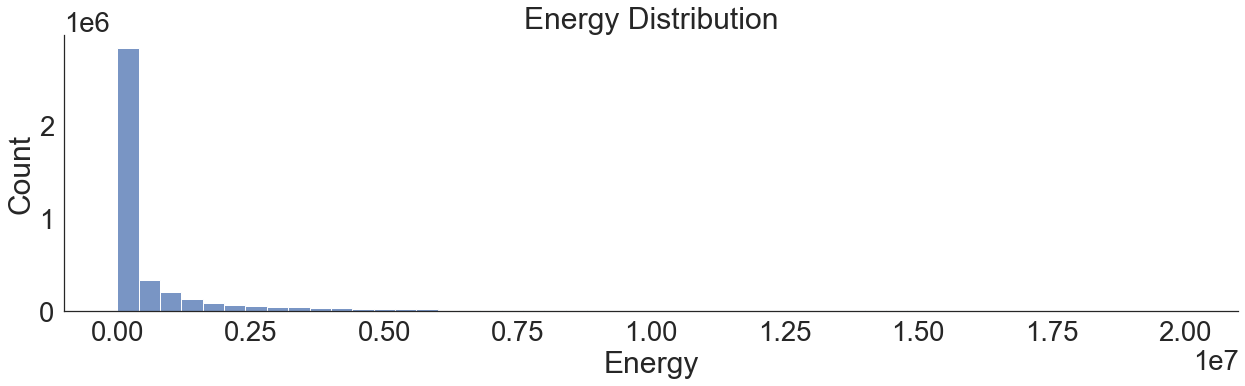

In [13]:
sns.displot(df[["Energy"]], x="Energy", height=6, aspect=3, bins=50)
plt.title("Energy Distribution")

There are various observations by just looking at some typical statistics:

1. Energy cannot be 0 so we have some incorrect datapoints. We dropped these.
2. The standard deviation is high but expected. This dataset includes reaction data for all isotopes and all reaction channels.
3. The energy is highly skewed (this will affects model performance).

There are many ways to un-skew the feature including log, square root, and power transformers. We know that our data is positive and cannot be zero so any of these works. Let us observe the impact of the log and Box Cox transformer on the skewness. The square root is not very powerful and will not be tested here (it has been tested before and the skewness change is minimal).

### Log10 Transformation

In [19]:
skew(np.log10(df[["Energy"]]).values) 

array([-0.62603645])

Text(0.5, 1.0, 'Energy Distribution after Log10')

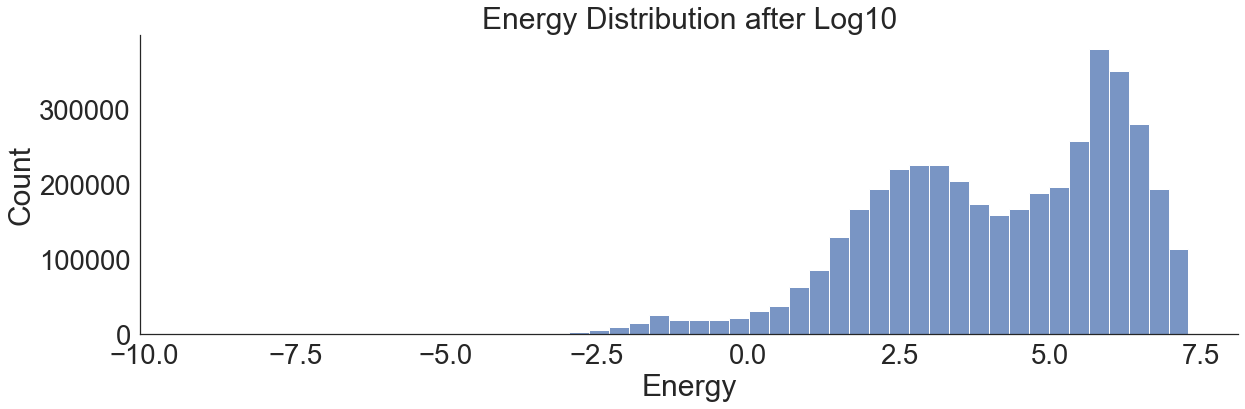

In [178]:
sns.displot(np.log10(df[["Energy"]]), x="Energy", height=6, aspect=3, bins=50)
plt.title("Energy Distribution after Log10")

### Box Cox Transform

In [22]:
from scipy import stats

energy_box, _= stats.boxcox(df.Energy.values)

In [28]:
skew(energy_box)

-0.09672338436387388

Text(0.5, 1.0, 'Energy Distribution after Box Cox')

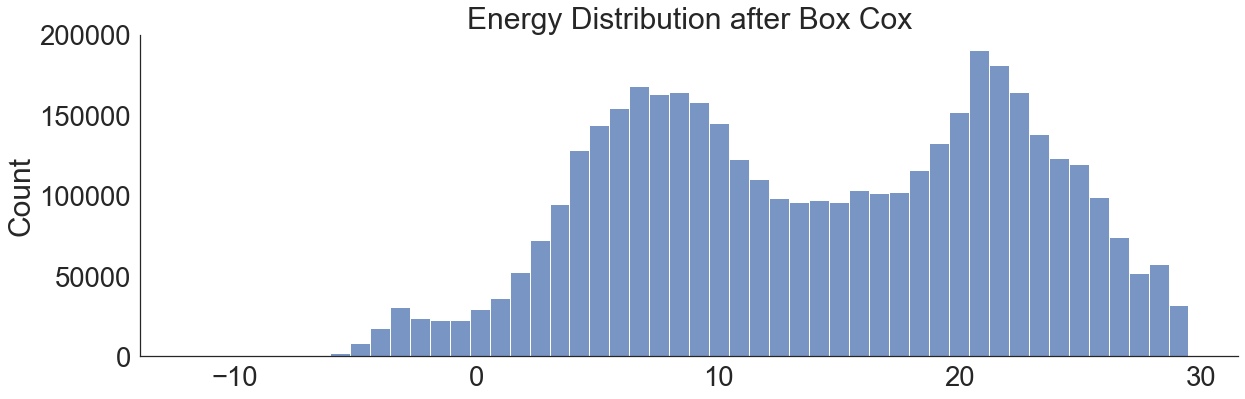

In [179]:
sns.displot(energy_box, height=6, aspect=3, bins=50)
plt.title("Energy Distribution after Box Cox")

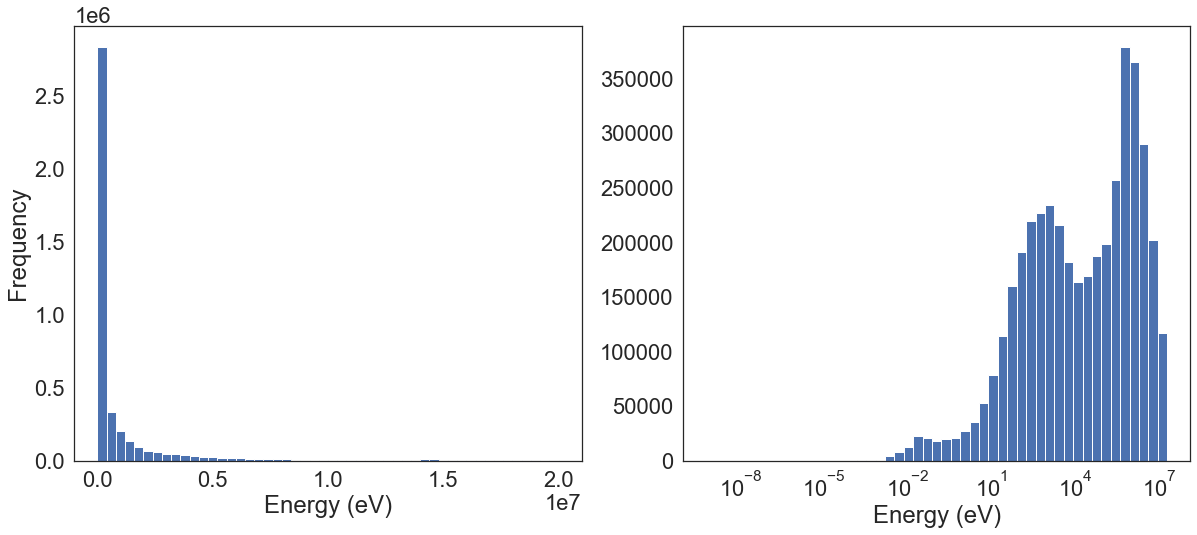

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.hist(df.Energy, bins=50)
ax2.hist(df[["Energy"]], bins = 10 ** np.linspace(np.log10(df.Energy.min()), np.log10(df.Energy.max()), 50))
ax2.set_xscale('log')
ax2.set_xlabel('Energy (eV)')
# ax2.set_ylabel('Frequency')
# ax1.get_yaxis().set_label_coords(-0.08,0.5)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Energy (eV)')
# ax2.get_yaxis().set_label_coords(-0.08,0.5)
plt.savefig(os.path.join(figure_dir, "energy_distribution_h.png"), bbox_inches='tight', dpi=300)

Either the log or Box Cox transformation followed by a standardizer or normalizer will benefit model performance by unskewing the data and minimizing the standard deviation. We shall keep this in mind when using any algorithm. 

## Cross Section (Data) Distribution - Label

The cross-section is our label making this a regression challenge. Similar to the Energy, we expect this feature to have high standard deviations and be highly skewed. However, we must be careful not to change the nature of the data. These values represent physical reaction probabilities (although not in the usual 0-1 scale). 

In [175]:
df.Data.describe()

count    4.185090e+06
mean     6.480420e+03
std      6.187566e+05
min      8.250000e-18
25%      2.695000e+00
50%      5.820400e+00
75%      1.404500e+01
max      2.311600e+08
Name: Data, dtype: float64

In [37]:
df = df[df.Data != 0]

In [38]:
skew(df.Data.values)

138.58342560709644

Text(0.5, 1.0, 'Data (Cross Section) Distribution')

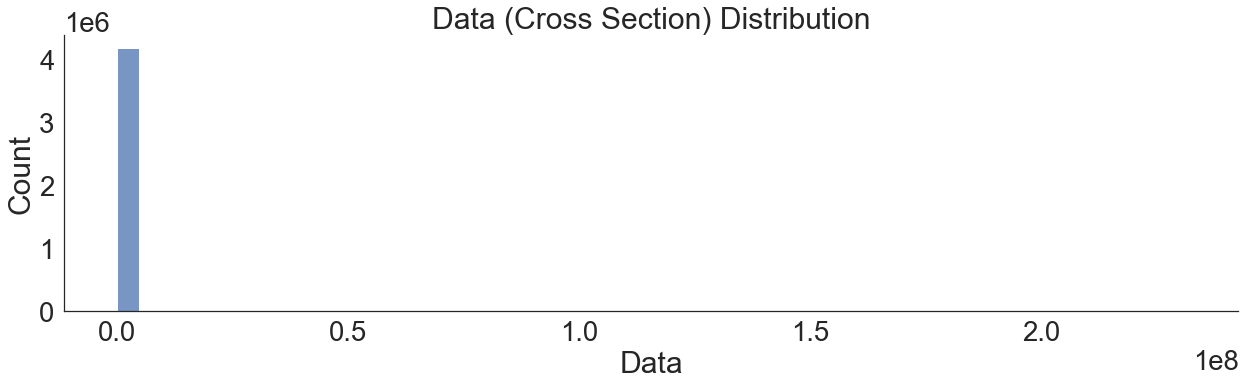

In [176]:
sns.displot(df[["Data"]], x="Data", height=6, aspect=3, bins=50)
plt.title("Data (Cross Section) Distribution")

There are various observations by just looking at some typical statistics:

1. Data cannot be 0 so we have some incorrect datapoints. We dropped these.
2. The standard deviation for the cross section is also high but expected. 
3. The cross section feature is highly skewed (this will affects model performance). 

We refrain from applying any other transformation other than the log transformation to not change the nature of the data. To optimize model raining (although model dependent), the features must have similar ranges. This helps algorithms like KNN not give more importance to high variance features and helps deep learning models train faster. However, we shall not normalize our labels (cross-section data) since these are absolute probabilities.

There are many ways to unskew the feature including log, square root, and power transformers. We know that our data is positive and cannot be zero so any of these work. Let us observe the impact of each transformer on the skewness.

### Log10 Transformation

In [180]:
skew(np.log10(df[["Data"]]).values)

array([-1.01712755])

Text(0.5, 1.0, 'Data (Cross Section) Distribution after Log10')

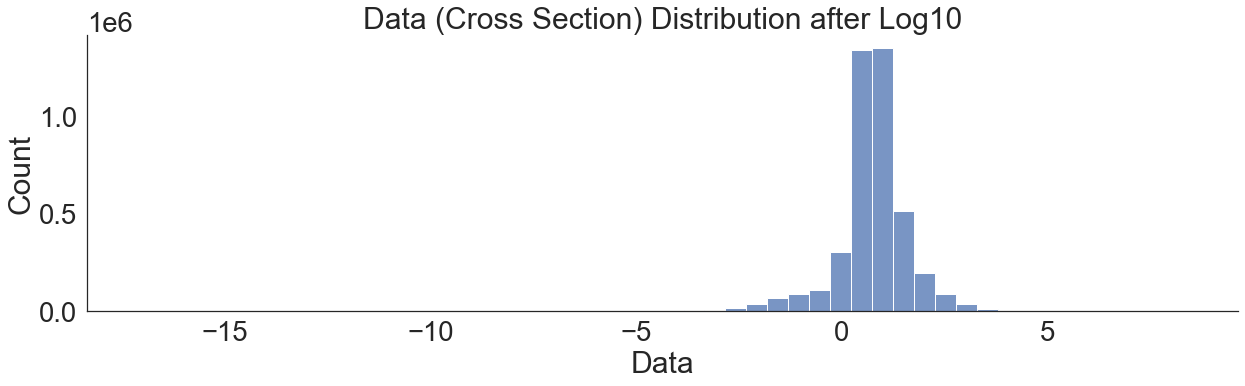

In [181]:
sns.displot(np.log10(df[["Data"]]), x="Data", height=6, aspect=3, bins=50)
plt.title("Data (Cross Section) Distribution after Log10")

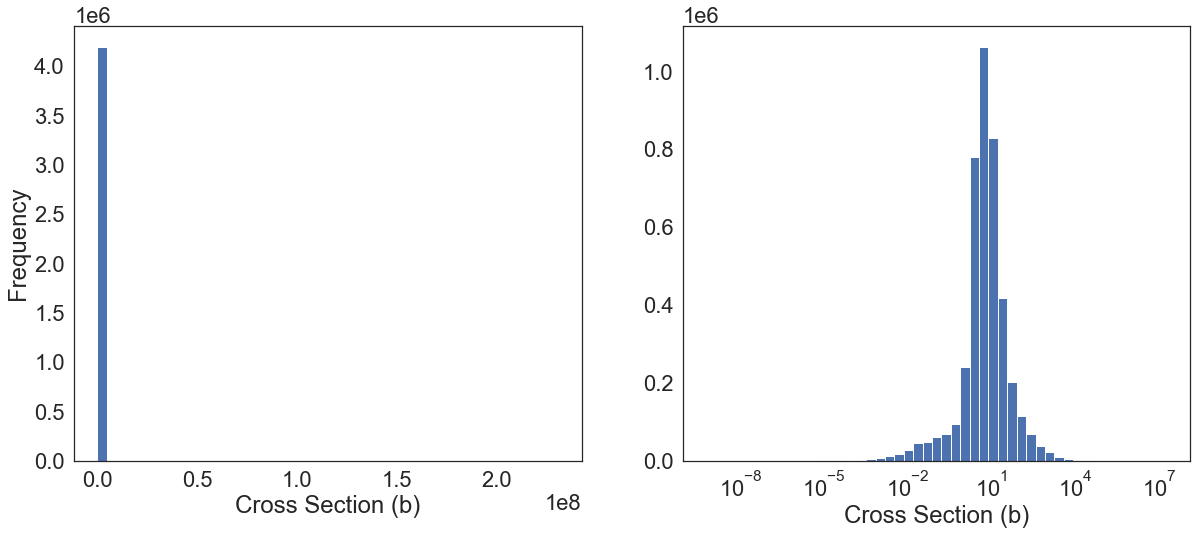

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.hist(df.Data, bins=50)
ax2.hist(df[["Data"]], bins = 10 ** np.linspace(np.log10(df.Energy.min()), np.log10(df.Energy.max()), 50))
ax2.set_xscale('log')
ax2.set_xlabel('Cross Section (b)')
# ax2.set_ylabel('Frequency')
# ax1.get_yaxis().set_label_coords(-0.08,0.5)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Cross Section (b)')
# ax2.get_yaxis().set_label_coords(-0.08,0.5)
plt.savefig(os.path.join(figure_dir, "xs_distribution_h.png"), bbox_inches='tight', dpi=300)

## Outliers in Energy and Data (Cross Section)

It is difficult to detect outliers in this particular dataset. The following image shows the U-235(N,G) reaction channel. This is an example of a single reaction for a single isotope. Typical statistics techniques for outlier detection will categorize resonances (peaks) points as outliers, however, these are not. These are the most important quantum physics phenomena that we need to model and can therefore not be disregarded.

In [60]:
u235_ng = exfor_utils.load_samples(df, 92, 235, 102)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (10872, 104)


In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
ax0.plot(x, y)
ax1 = plt.subplot(gs[1])
ax1.plot(y, x)

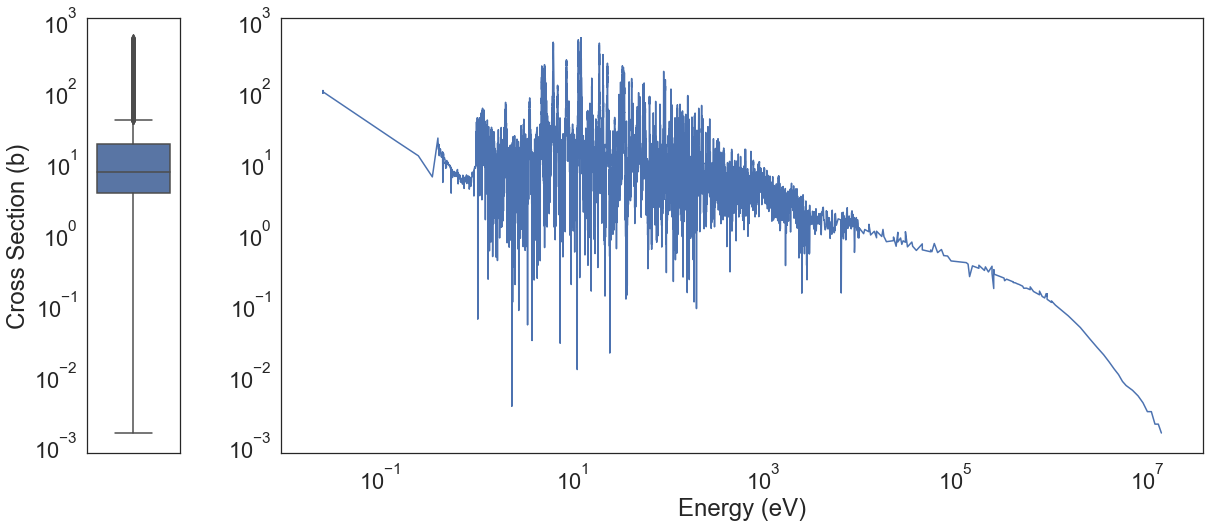

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [1, 10]})
sns.boxplot(y=u235_ng[["Data"]].values, ax=ax1)
ax1.set_yscale('log')
ax2.loglog(u235_ng.Energy, u235_ng.Data)

ax1.set_ylabel("Cross Section (b)")
ax2.set_xlabel("Energy (eV)")

plt.savefig(os.path.join(figure_dir, "u235_ng_xs_dist.png"), bbox_inches='tight', dpi=300)

As an example let us use the quantile information to remove some "outliers" for this particular reaction only.

In [107]:
without_outliers = u235_ng[np.log10(u235_ng.Data) < np.log10(u235_ng.Data).quantile(.75)]
# without_outliers = without_outliers[np.log10(without_outliers.Data) > np.log10(without_outliers.Data).quantile(.05)]

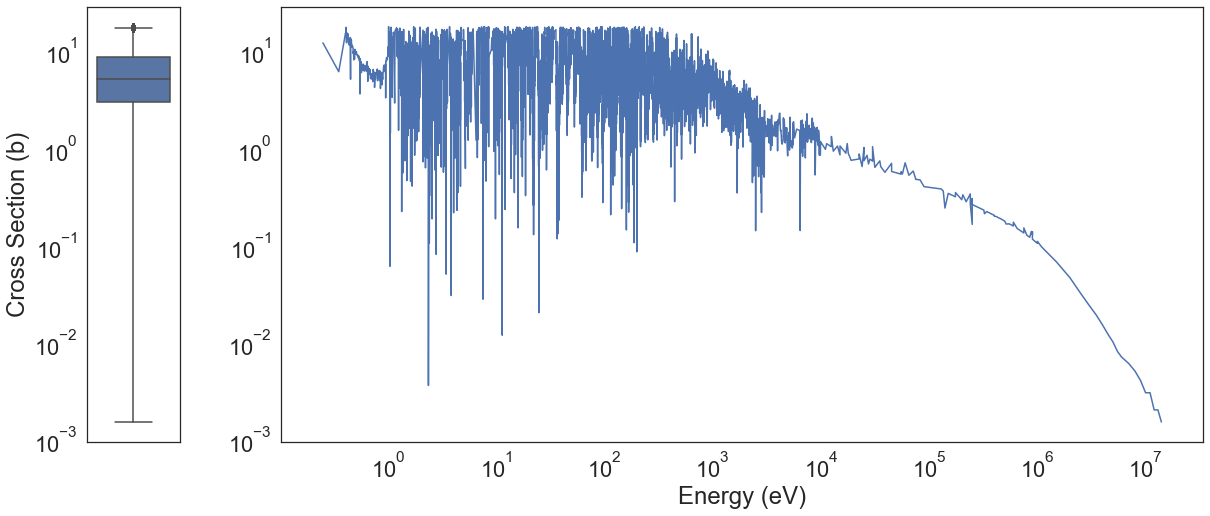

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [1, 10]})
sns.boxplot(y=without_outliers[["Data"]].values, ax=ax1)
ax1.set_yscale('log')
ax2.loglog(without_outliers.Energy, without_outliers.Data)

ax1.set_ylabel("Cross Section (b)")
ax2.set_xlabel("Energy (eV)")

plt.savefig(os.path.join(figure_dir, "u235_ng_xs_dist_without_outliers.png"), bbox_inches='tight', dpi=300)

These types of processes are not acceptable. We lose a lot of useful information. In another notebook, we shall use more advanced methods including robust covariance, one-class SVM, and isolation forests to try and clean the data better. 

In a different note, another benefit of applying a log transformation is the easy visualization and the creation of correlation.

In [236]:
u235_ng[["Energy", "Data"]].corr()

,Energy,Data
Energy,1.000000,-0.019248
Data,-0.019248,1.000000


In [237]:
np.log10(u235_ng[["Energy", "Data"]]).corr()

,Energy,Data
Energy,1.000000,-0.430042
Data,-0.430042,1.000000


## Reaction Channel (MT Values) - Categorical

Before modeling the EXFOR database, we need to understand the possible limitations of any model using this data. There are a variety of reaction channels but not all of them all well researched. Knowing the reaction class balances will allow us to have a certain degree of confidence when deploying a model. 

In [192]:
# This file contains the meaning of each MT code, useful for plotting
mt_codes = pd.read_csv("../CSV_Files/mt_codes.csv")
mt_codes["MT"] = mt_codes.astype(str)
mt_codes = mt_codes[["MT", "MT_Reaction_Notation"]]

MT_value_counts = df.MT.astype(str).value_counts()
MT_value_counts = pd.DataFrame(MT_value_counts).reset_index()
MT_value_counts.columns = ["MT", "Count"]

MT_value_counts = mt_codes.merge(MT_value_counts).sort_values(by="Count", ascending=False)
MT_value_counts["MT"] = MT_value_counts["MT"].astype(int)

**What are the highest researched reaction channels?**

It appears that (n, fission) is the most researched reaction. This makes sense since many resources have been spent trying to understand fission, especially since it is by this mechanism that nuclear reactors and weapons work. The next one is (N,G), a reaction important for studies in safety and neutron moderation.

In [193]:
MT_value_counts[1:10]

,MT,MT_Reaction_Notation,Count
6,18,"(n,fission)",507541
17,102,"(n,g)",215904
34,9000,Production Data,84333
15,51,"(n,n1)",49835
3,4,"(n,inelastic)",37641
1,2,"(n,elastic)",37296
18,103,"(n,p)",17270
22,107,"(n,a)",15295
4,16,"(n,2n)",10930


**What is the label (cross-section) distribution as a function of the reaction channel?**

There is no need to look at the distribution of cross-section data in regards to the reaction channel. Usual statistics will not work here. The cross-section ranges are a function of the element/isotope, and the reaction channel. Statistics based on the entire dataset will result in erroneous conclusions. As an example, let us observe the `Data` distribution of the most researched channels.

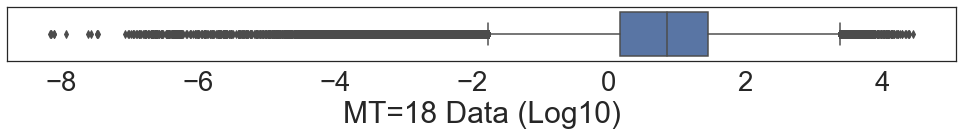

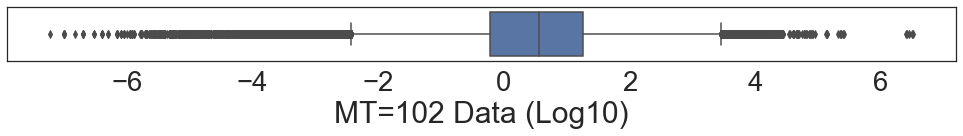

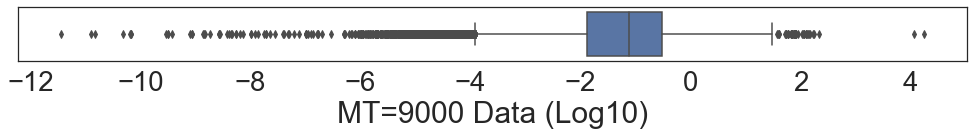

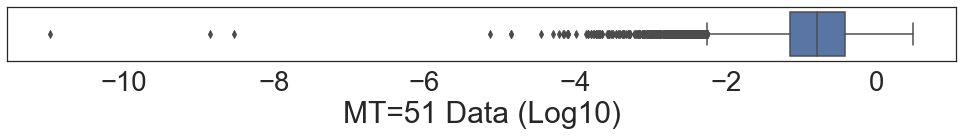

In [102]:
for i in MT_value_counts[1:5].MT.values:
    plt.figure(figsize=(17,1))
    sns.boxplot(x=np.log10(df[df.MT == int(i)].Data).values)
    plt.xlabel("MT={} Data (Log10)".format(i))

**What are the lowest researched reaction channels?**

Reactions with a high number of outgoing particles have much lower probabilities than those with only one or two resulting particles. It will be harder to model these types of reactions but representing this feature as numerical might help extrapolate knowledge from the other highly researched reactions. For know, let us confirm our expectations.

In [104]:
MT_value_counts[-10:]

,MT,MT_Reaction_Notation,Count
25,112,"(n,p+a)",20
33,2103,"(n,p)DI",17
30,203,"(n,Xp)",9
14,41,"(n,2n+p)",7
23,108,"(n,2a)",6
28,158,"(n,n+a+d)",5
26,113,"(n,t+2a)",2
32,1108,"(n,2a)CALC",2
29,159,"(n,2n+p+a)",1
13,37,"(n,4n)",1


These reactions are expected to have similar ranges in terms of Cross Section so we can plot them.

In [194]:
low_research = df[df['MT'].astype(str).isin(MT_value_counts[-10:].MT.values.astype(str))]

Text(0.5, 28.400000000000034, 'Reaction Channel (MT)')

<Figure size 1008x576 with 0 Axes>

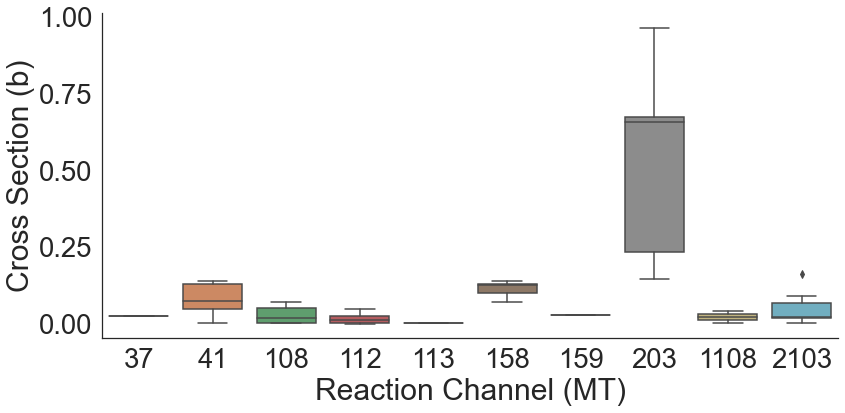

In [198]:
plt.figure(figsize=(14,8))
sns.catplot(x="MT", y="Data", data=low_research, height=6, aspect=2, kind="box")
plt.ylabel("Cross Section (b)")
plt.xlabel("Reaction Channel (MT)")

## Proton and Neutron Distribution

Previously we mentioned that the most important features are the Energy, Reaction Channel, and the Isotope. **What characterizes the isotope?** The isotope is made of neutrons and protons. Understanding the distributions will help us understand in what regions our models are expected to perform well and for which isotopes the performance might be poor.

C:\Users\Pedro\Anaconda3\envs\tf_nightly\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Pedro\Anaconda3\envs\tf_nightly\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


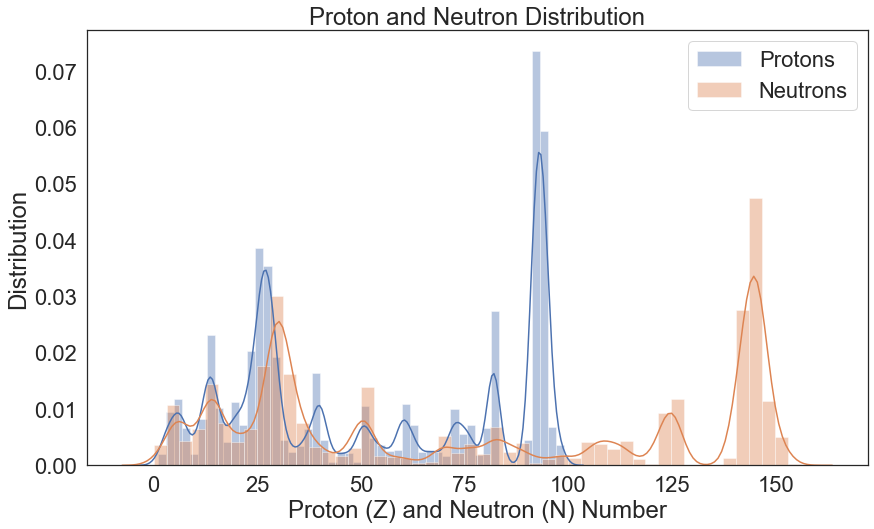

In [21]:
plt.figure(figsize=(14,8))
sns.distplot(df.Z.values, label="Protons")
sns.distplot(df.N.values, label="Neutrons")
# plt.xlabel('Number of Neutrons')
plt.ylabel('Distribution')
plt.xlabel('Proton (Z) and Neutron (N) Number')
plt.legend()
plt.title("Proton and Neutron Distribution")
plt.savefig(os.path.join(figure_dir, "proton_neutron_distribution.png"), bbox_inches='tight', dpi=300)

Apparently, we have a lot of data for:

- Isotopes with protons and neutrons near 26 (~Iron)
- Neutrons in the 145 range (~Uranium, Plutonium)
- Protons in the 92 range (~Uranium)

## Experimental Campaigns per Year

One of the biggest challenges with this data set is the measurement uncertainties. These are usually reported when creating an entry in EXFOR. However, there are plenty of missing values for uncertainties in terms of both the Energy and the Data. These are suspected to be mostly in old measurements. Let us explore the dataset to find out.

In [23]:
df_original = pd.read_csv("../CSV_Files/EXFOR_neutrons/EXFOR_neutrons_ORIGINAL.csv")

C:\Users\Pedro\Anaconda3\envs\tf_nightly\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [209]:
missing_uncertanties_data = len(df_original[df_original["dData"].isnull()]) / len(df_original)
print("{0:.2f}% of the uncertainties in Cross Section are missing".format(missing_uncertanties_data*100))

18.00% of the uncertainties in Cross Section are missing


In [211]:
missing_uncertanties_energy = len(df_original[df_original["dEnergy"].isnull()]) / len(df_original)
print("{0:.2f}% of the uncertainties in Energy are missing".format(missing_uncertanties_energy*100))

77.02% of the uncertainties in Energy are missing


**Massive amounts of data did not report uncertainties in either Energy or the Cross-Section**. The high number of missing values will present a unique challenge if we are to model uncertainties also in multi-output regression.

In [24]:
years_with_missing_uncertainties = df_original[df_original['dData'].isnull()].Year
institutes_with_missing_uncertainties = df_original[df_original['dData'].isnull()].Institute

In [25]:
years_with_missing_uncertainties_e = df_original[df_original['dEnergy'].isnull()].Year

Text(0.5, 1.0, '(a)')

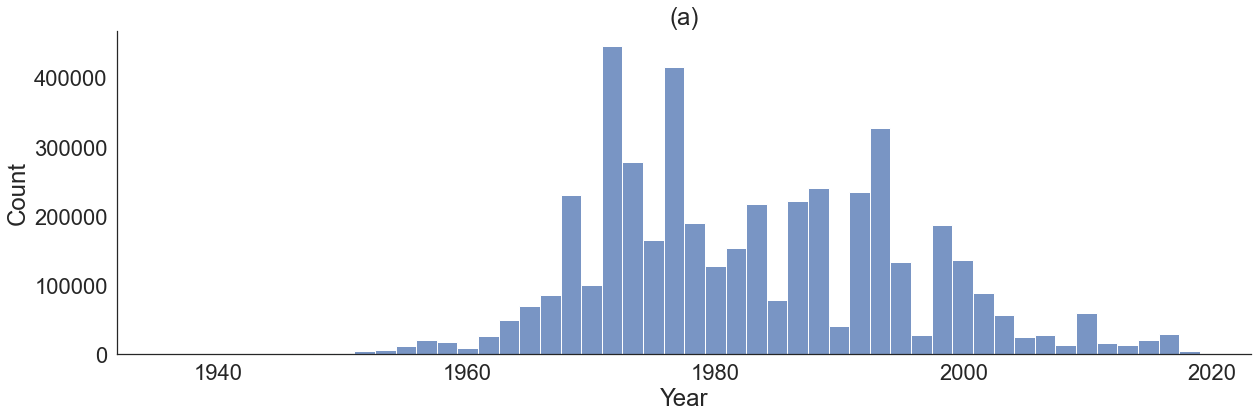

In [28]:
sns.displot(years_with_missing_uncertainties_e, height=6, aspect=3, bins=50)
plt.title("(a)")

Text(0.5, 1.0, 'Missing Values per Year')

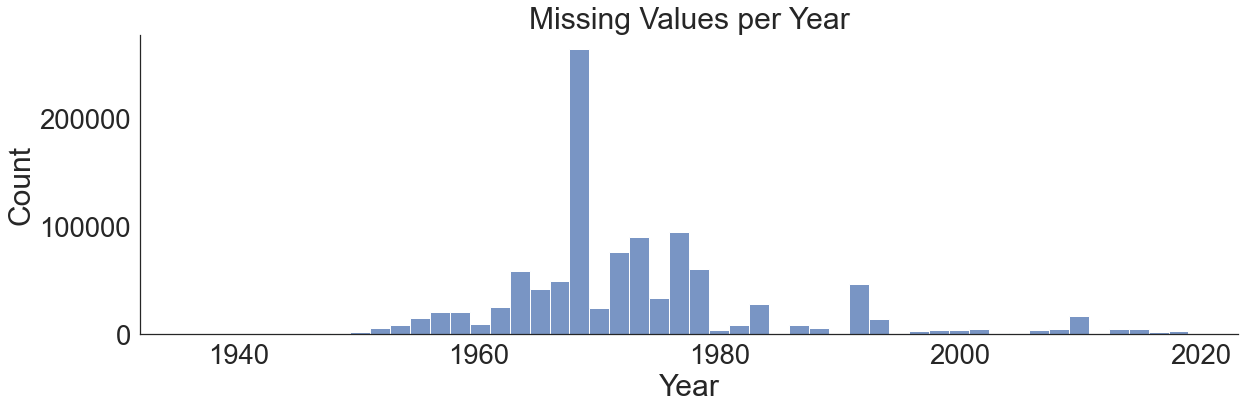

In [212]:
sns.displot(years_with_missing_uncertainties, height=6, aspect=3, bins=50)
plt.title("Missing Values per Year")
plt.savefig(os.path.join(figure_dir, "missing.png"), bbox_inches='tight', dpi=300)

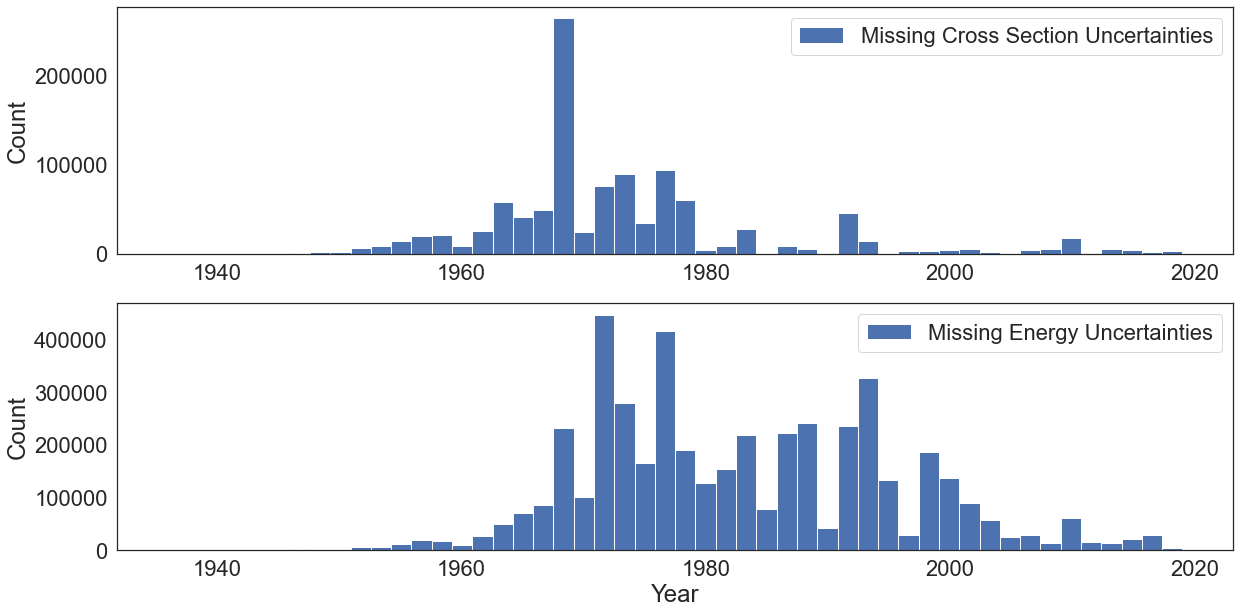

In [42]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,10))
ax1.hist(years_with_missing_uncertainties, bins=50, label="Missing Cross Section Uncertainties")
ax2.hist(years_with_missing_uncertainties_e, bins=50, label="Missing Energy Uncertainties")
ax1.set_ylabel('Count')
ax2.set_ylabel('Count')               
ax2.set_xlabel('Year')
ax1.legend()
ax2.legend()
plt.savefig(os.path.join(figure_dir, "xs_e_unc_hist.png"), bbox_inches='tight', dpi=300)

Indeed, most of the measurements perform from the 50s to the 80s simply did not reported uncertainties. **What institutes are responsible for the datapoints containing missing uncertainties?**

In [167]:
institutes_with_missing_uncertainties = institutes_with_missing_uncertainties.value_counts()[:10]
institutes_with_missing_uncertainties = pd.DataFrame(institutes_with_missing_uncertainties).reset_index()
institutes_with_missing_uncertainties.columns = ["Institute", "Count"]

In [168]:
institutes_with_missing_uncertainties

,Institute,Count
0,1USAORL,152356
1,1USACOL,149661
2,1USALAS,121619
3,2GERKFK,117092
4,1USARPI,109206
5,2ZZZGEL,73840
6,1USAANL,41487
7,1USADKE,33990
8,1USAMTR,25559
9,2AUSIRK,24367


Interestingly, ORNL-based experimental campaigns failed the most to report uncertainties followed by Columbia University. Should we use the uncertainties feature or should we drop these and focus on the raw data?

## Isotope Distributions

**What are the highest researched isotopes?** Fe-56, Pu-239, U-235, 238U 233U Al-27 Np-237, 91Zr cover the majority of the measurements here.

In [9]:
isotope_distribution = pd.DataFrame(df.Isotope.value_counts()).reset_index()
isotope_distribution.columns = ["Isotope", "Count"]
# print(isotope_distribution.to_latex(index=False))

In [220]:
isotope_distribution[:10]

,Isotope,Count
0,56Fe,234812
1,239Pu,213238
2,235U,186202
3,233U,132829
4,238U,126862
5,237Np,121401
6,91Zr,102523
7,28Si,96671
8,241Pu,94860
9,207Pb,93372


In [12]:
isotope_distribution[-15:].sort_values(by="Isotope")

,Isotope,Count
524,132Cs,1
521,134Ce,1
514,135Ce,1
518,143Ce,1
515,146Pm,1
527,151Pm,1
525,161Gd,1
520,175Yb,1
517,203Hg,1
526,210Pb,1


**Why do we have so little measurments for many of these isotopes?** Many of these are radioactive and difficult to work with experimentally. A machine learning model might be able to extrapolate knowledge.

## Nucleus Radius and Neutron-to-Nucleus Radius Ratio

The cross sections is purely a gemoetrical concept. Quantum effects makes the reaction probabilities not be just a function of the size of the nucleus. However, there are some reactions in which the geometrical cross section is a good approximation. Because of this we created the nucleus radius and the neutron-to-nucleus radius ratio features. 

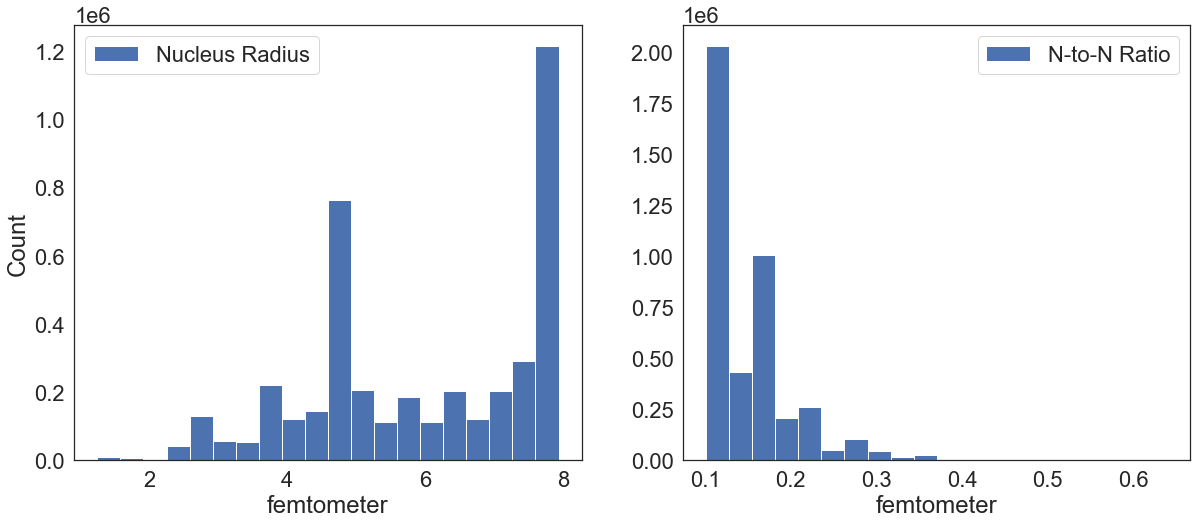

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.hist(df.Nucleus_Radius.values, label="Nucleus Radius", bins=20)
ax2.hist(df.Neutron_Nucleus_Radius_Ratio.values, label="N-to-N Ratio", bins=20)
ax1.set_ylabel("Count")
ax1.set_xlabel("femtometer")
ax2.set_xlabel("femtometer")
ax1.legend()
ax2.legend()
plt.savefig(os.path.join(figure_dir, "nucleus_radius_ratio.png"), bbox_inches='tight', dpi=300)

## Element Flag (Natural and Isotopic Measurments)

How many datapoints were measrued on pure isotopic samples and how many in natural targets?

In [169]:
df.Element_Flag.value_counts()

I    3184818
N    1000272
Name: Element_Flag, dtype: int64

## EXFOR Status

The EXFOR status is a tag placed by the database managers to indicate if it is approved, outdated, renormalized, correlated, and so on. This is a human tag and will therefore note be included for training to avoid bias. 

In [113]:
pd.DataFrame(df.EXFOR_Status.value_counts())

,EXFOR_Status
Other,2165207
Approved_by_Author,1642322
Correlated,231122
Dependent,123446
Preliminary,20306
Outdated,2512
Re_normalized,175


## Original

In [4]:
df_original.columns

Index(['Projectile', 'Target_Metastable_State', 'MF', 'MT',
       'Product_Metastable_State', 'EXFOR_Status', 'Center_of_Mass_Flag',
       'Energy', 'dEnergy', 'Data', 'dData', 'Cos/LO', 'dCos/LO', 'ELV/HL',
       'dELV/HL', 'I78', 'Short_Reference', 'EXFOR_Accession_Number',
       'EXFOR_SubAccession_Number', 'EXFOR_Pointer', 'Z', 'A', 'N',
       'Reaction_Notation', 'Title', 'Year', 'Author', 'Institute', 'Date',
       'Reference', 'Dataset_Number', 'EXFOR_Entry', 'Reference_Code',
       'Projectile_Z', 'Projectile_A', 'Projectile_N', 'Isotope', 'Element'],
      dtype='object')